In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!nvidia-smi

Thu May  5 23:50:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 33.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.4 MB/s 
     |████████████████████████████████| 596 kB 67.7 MB/s 
     |████████████████████████████████| 77 kB 8.5 MB/s 
     |████████████████████████████████| 880 kB 62.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=3ac5294aeeb16aa8718fa96adac0769208bd0c718daced2fec197e48d9f0b3ac
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
##importing all the packages

import os
import sys
import torch
from transformers import BertForTokenClassification
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import csv,pprint,datetime,random,time
import numpy as np
from sklearn import metrics


In [7]:
###initializing the directories 

home_dir = "gdrive/My Drive/project_5_data"
data_dir = os.path.join(home_dir, "datasets")
model_dir = os.path.join(home_dir, "model_dir")
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [8]:
def read_articles(article_dir):
  '''Function to read articles from the given folders '''

  articles = []

  article_dir = os.path.join(data_dir, article_dir)
  articles_files=sorted(os.listdir(article_dir))
  print(articles_files)
  for filename in articles_files:
    f = open(os.path.join(article_dir, filename))
    article = f.read()
    articles.append(article)
    f.close()

  article_ids = []
  article_fullnames=[]
  for filename in articles_files:
    
    tmp=filename[7:-4]
    article_ids.append(tmp)
    article_fullnames.append(filename)
  return articles, article_ids,article_fullnames

In [9]:
#a1, a2,a3=read_articles('test-articles')

In [10]:
#len(a3)

In [11]:
# Read training span labels 
def read_spans(mode=None):
  spans,techniques = [],[]
  if mode == "test":
    label_dir = os.path.join(data_dir, "dev-labels-task-flc-tc")
  else:
    label_dir = os.path.join(data_dir, "train-labels-task-flc-tc")
  sorted_lst=sorted(os.listdir(label_dir))
  for filename in sorted_lst:

    f = open(os.path.join(label_dir, filename))
    filereader = csv.reader(f, delimiter="\t")
    span,technique = [],[]
    for row in filereader:
      span.append((int(row[2]), int(row[3])))
      if mode == "test":
        technique.append("Slogans")
      else:
        technique.append(row[1])
    f.close()
    spans.append(span)
    techniques.append(technique)
  return spans, techniques

In [12]:
# Read dev span labels 
def read_dev_spans():
  spans,techniques = [],[]
  label_file = os.path.join(data_dir, "dev-task-flc-tc.labels")
  f = open(label_file)
  prev_index = -1. #just to make sure to know if the prevfile is same or not
  filereader = csv.reader(f, delimiter="\t")

  span,technique = [],[]
  for line in filereader:

    article_index = int(line[0])
    if article_index != prev_index:
      if prev_index != -1:
        spans.append(span)
        techniques.append(technique)
      span = []
      technique = []
      span.append((int(line[2]), int(line[3])))
      technique.append("Slogans")
      prev_index = article_index
    else:
      span.append((int(line[2]), int(line[3])))
      technique.append("Slogans")
  spans.append(span)
  techniques.append(technique)
  return spans, techniques, 

In [13]:
# Read training span labels 
def read_test_spans():
  spans,techniques = [],[]
  label_file = os.path.join(data_dir, "test-task-tc-template.out")
  f = open(label_file)
  prev_index = -1
  filereader = csv.reader(f, delimiter="\t")

  span,technique = [],[]
  for line in filereader:
    article_index = int(line[0])
    if article_index != prev_index:
      if prev_index != -1:
        spans.append(span)
        techniques.append(technique)
      span = []
      technique = []
      span.append((int(line[2]), int(line[3])))
      technique.append("Slogans")
      prev_index = article_index
    else:
      span.append((int(line[2]), int(line[3])))
      technique.append("Slogans")
  spans.append(span)
  techniques.append(technique)
  return spans, techniques

In [14]:
def print_spans(article, spans, techniques):
  for idx, s in enumerate(spans):
    print(techniques[idx], label2idx[techniques[idx]], end=' - ')
    print (article[s[0]: s[1]])
  return 'ALL SPANS PRINTED'

In [15]:
def get_context(article, span, mode=None):

  def words_count(sentence):
    return len(sentence.split(' '))

  if mode == "title":

    return article.split('\n')[0]
  if mode == "sentence":

    #setting the word limit to 150 which would get context upto 150 words.
    #Morethan this would make it too long.

    word_limit = 150
    start = span[0]
    end = span[1]
    span_text = article[start: end]
    word_count = words_count(span_text)
    if word_count >= word_limit:
      return span_text
    remaining_len = word_limit - word_count
    left_words = remaining_len // 2
    right_words = remaining_len - left_words
    try:

      if article[start-1]:

        start -= 1
  
    except:
      start=start
      pass


    l_word_count = 0
    print(start,end)

    ##checking for both left hand and rihht hand side words
    while start >= 0  and l_word_count < left_words and article[start] != '\n':
      if article[start] == ' ':
        l_word_count += 1
      start -= 1
    end += 1


    r_word_count = 0
    while end < len(article) and article[end] != '\n' and r_word_count < right_words:
      if article[end] == ' ':
        r_word_count += 1
      end += 1

    return article[start+1: end - 1] 

  return ""

In [16]:
def get_examples(articles, spans, techniques, context_mode=None):

  ##raise error if tehre is length mismatch
  assert len(articles) == len(spans) and len(spans) == len(techniques)
  labels,sentences,sent_contexts= [],[],[]

  for idx, arti in enumerate(articles):
    span = spans[idx]
    technique = techniques[idx]
    assert len(technique) == len(span)
    for i, sp in enumerate(span):
      pt = label2idx[technique[i]]
      sentence = arti[sp[0]: sp[1]]
      sentences.append(sentence)
      labels.append(pt)

      context = get_context(arti, sp, context_mode)
      sent_contexts.append(context)
  return sentences, labels, sent_contexts

In [17]:


def convert_sentence_to_input_feature(sentence,
                                      tokenizer,
                                      add_cls_sep=True,
                                      max_seq_len=150, 
                                      context=None):
  
  sentence_tokenized = tokenizer.encode_plus(sentence,
                                             add_special_tokens=add_cls_sep,
                                             pad_to_max_length=True,
                                             max_length=max_seq_len,
                                             return_attention_mask=True)
  
  context_tokenized = tokenizer.encode_plus(context,
                                            add_special_tokens=add_cls_sep,
                                            max_length=max_seq_len,
                                            pad_to_max_length=True,
                                            return_attention_mask=True)
  
  return sentence_tokenized['input_ids'], sentence_tokenized['attention_mask'], context_tokenized['input_ids'], context_tokenized['attention_mask']

In [18]:

def get_data(articles, spans, techniques, context_mode=None):


  if context_mode is None:
    context_mode = CONTEXT_MODE #hyp param
    # context_mode = 'title' #hyp param


  sentences, labels, contexts = get_examples(articles, spans, techniques, context_mode=context_mode)
  context_inputs,context_attention_masks = [],[]
  sent_inputs,sent_attention_masks = [],[]

  for i, sentence in enumerate(sentences):
    s_input_ids, s_mask, c_input_ids, c_mask = convert_sentence_to_input_feature(sentence, tokenizer, context=contexts[i])
    sent_inputs.append(s_input_ids)
    sent_attention_masks.append(s_mask)
    context_inputs.append(c_input_ids)
    context_attention_masks.append(c_mask)

  max_sent_len = 0
  for sent in sentences:
    sent_len = len(sent.split(' '))
    max_sent_len = max(max_sent_len, sent_len)
  max_context_len = 0
  for sent in contexts:
    sent_len = len(sent.split(' '))
    max_context_len = max(max_context_len, sent_len)
  print(max_sent_len, max_context_len)


  ##convert the list of input featueres into torch tensors to load into dataloader.
  sent_inputs = torch.tensor(sent_inputs)
  context_inputs = torch.tensor(context_inputs)
  labels = torch.tensor(labels)
  sent_masks = torch.tensor(sent_attention_masks)
  context_masks = torch.tensor(context_attention_masks)


  tensor_data_as_inp = TensorDataset(sent_inputs, labels, sent_masks, context_inputs, context_masks)
  dataloader = DataLoader(tensor_data_as_inp, batch_size=BATCH_SIZE) ##hyper param
  return dataloader

In [19]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [20]:
from torch.nn import CrossEntropyLoss, MSELoss

class ContextualBertForSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels, ContextModel, SpanModel):
    super(ContextualBertForSequenceClassification, self).__init__()
    self.ContextModel = ContextModel
    self.SpanModel = SpanModel
    self.num_labels = num_labels

    # self.classifier = torch.nn.Linear(768*2, num_labels)
    # self.classifier1 = torch.nn.Linear(768, num_labels)

    
    self.classifier_custom = torch.nn.Linear(768+128, num_labels)
    self.reduce_classifier = torch.nn.Linear(768, 128)
    self.dropout = torch.nn.Dropout(0.1)

  def forward(
      self,
      span_input_ids,
      span_attention_mask,
      context_input_ids,
      context_attention_mask,
      labels=None
  ):
    context_outputs = self.ContextModel(
        input_ids=context_input_ids,
        attention_mask=context_attention_mask
    )
    context_outputs = context_outputs[1] 
    span_outputs = self.SpanModel(
        input_ids=span_input_ids,
        attention_mask=span_attention_mask
    )
    span_outputs = span_outputs[1]

    context_outputs = self.reduce_classifier(context_outputs)
    pooled_output = torch.cat((span_outputs, context_outputs), axis=1)

    pooled_output = self.dropout(pooled_output)

    ##get the logit
    logits = self.classifier_custom(pooled_output)
    outputs = (logits,)

    
    if labels is not None:
      if self.num_labels == 1:
        loss_func = MSELoss()
        loss = loss_func(logits.view(-1), labels.view(-1))
      else:
        loss_func = CrossEntropyLoss()
        loss = loss_func(logits.view(-1, self.num_labels), labels.view(-1))
      outputs = (loss,) + outputs

    return outputs

In [21]:
def generate_metrics(preds, labels):
  preds = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()
  print(metrics.confusion_matrix(labels, preds))
  print(metrics.classification_report(labels, preds))



In [22]:
def calc_accuracy(preds, labels):
  preds = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()
  return np.sum(preds == labels) / len(labels)

In [23]:
def train(model, epochs=5):
  loss_values = []
  for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
      if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
      b_input_ids = batch[0].to(device)
      b_labels = batch[1].to(device)
      b_input_mask = batch[2].to(device)
      b_c_input_ids = batch[3].to(device)
      b_c_input_mask = batch[4].to(device)
      model.zero_grad()        
      outputs = model(b_input_ids, 
                      b_input_mask,
                      b_c_input_ids, 
                      b_c_input_mask, 
                      labels=b_labels)
      loss = outputs[0]
      total_loss += loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step() # TODO
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in eval_dataloader:
      # batch = tuple(t.to(device) for t in batch)
      b_input_ids = batch[0].to(device)
      b_labels = batch[1].to(device)
      b_input_mask = batch[2].to(device)
      b_c_input_ids = batch[3].to(device)
      b_c_input_mask = batch[4].to(device)
      with torch.no_grad():        
        outputs = model(b_input_ids, 
                        b_input_mask,
                        b_c_input_ids, 
                        b_c_input_mask)
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      tmp_eval_accuracy = calc_accuracy(logits, label_ids)
      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
  print("")
  print("Training complete!")

In [ ]:

#save the model TC
# model_name = 'model_' + str(datetime.datetime.now()) + '.pt'
# torch.save(model, os.path.join(model_dir, model_name))
# print("Model saved:", model_name)

In [25]:
def get_model_predictions(model, dataloader):
  model.eval()
  predictions , true_labels = [], []
  nb_eval_steps = 0
  for batch in dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)
    b_input_mask = batch[2].to(device)
    b_c_input_ids = batch[3].to(device)
    b_c_input_mask = batch[4].to(device)
    with torch.no_grad():        
      logits = model(b_input_ids, 
                     b_input_mask,
                     b_c_input_ids, 
                     b_c_input_mask)
    logits = logits[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred_label = np.argmax(logits, axis=1)
    predictions.extend(pred_label)
    true_labels.extend(label_ids)
  return predictions, true_labels

In [26]:
from google.colab import files

def get_dev_predictions(model):
  dev_articles, _,_ = read_articles("dev-articles")
  dev_spans, dev_techniques = read_dev_spans()

  dev_articles = dev_articles[1:]
  print('test article count',len(dev_articles))
  print('test spans len',len(dev_spans))
  dev_dataloader = get_data(dev_articles, dev_spans, dev_techniques)
  pred, _ = get_model_predictions(model, dev_dataloader)

  with open('predictions_tc.txt', 'w') as fp:
    label_file = os.path.join(data_dir, "dev-task-flc-tc.labels")
    myfile = open(label_file)
    prev_index = -1
    tsvreader = csv.reader(myfile, delimiter="\t")
    for i, row in enumerate(tsvreader):
      fp.write(row[0] + '\t' + distinct_techniques[pred[i]] + '\t' + row[2] + '\t' + row[3] + '\n')

In [27]:
import pandas as pd


def clean_test_data():


  label_file = os.path.join(data_dir, "test-task-tc-template.out")
  myfile = open(label_file)
  prev_index = -1
  tsvreader = csv.reader(myfile, delimiter="\t")
  df = pd.DataFrame(tsvreader, index=None)
  # df.head()
  file_ids=df[0].to_list()
  file_ids=list(set(file_ids))
  print(len(file_ids))
  return file_ids

In [ ]:
# file_ids=clean_test_data()

87


In [28]:
from google.colab import files

from pathlib import Path

def get_test_predictions(model):
  test_articles,article_ids,article_fullnames = read_articles("test-articles")
  test_spans, test_techniques = read_test_spans()
  # data_dir = os.path.join(home_dir, "datasets") 
  # test_art_dir=os.path.join(data_dir,"test-articles")
  # for id in article_ids:
  #   # test_art_file=os.path.join(test_art_dir,article_name)
  #   # my_file = Path(test_art_file)
  #   # if my_file.is_file():
  #   #   print('file is present')
  #   # else:
  #   #   print('file not present')
  #   if id in file_ids:
  #     print('file is present')
  #   else:
  #     print(id)



  
  test_articles = test_articles[:]
  print('test article count',len(test_articles))
  print('test spans len',len(test_spans))
  test_dataloader = get_data(test_articles, test_spans, test_techniques)
  pred, _ = get_model_predictions(model, test_dataloader)

  with open('predictions_tc_test.txt', 'w') as fp:
    label_file = os.path.join(data_dir, "test-task-tc-template.out")
    myfile = open(label_file)
    prev_index = -1
    tsvreader = csv.reader(myfile, delimiter="\t")

    for i, row in enumerate(tsvreader):
      fp.write(row[0] + '\t' + distinct_techniques[pred[i]] + '\t' + row[2] + '\t' + row[3] + '\n')

In [ ]:
BATCH_SIZE=8
test_size = 0.1
seed_val = 2022

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [29]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import RobertaTokenizer

articles, article_ids,_ = read_articles("train-articles")
spans, techniques = read_spans()


all_techniques = list(set([y for x in techniques for y in x])) 

label2idx = {t: i for i, t in enumerate(all_techniques)}
# pprint.pprint(label2idx)
print(label2idx)

num_artilces = len(articles)
articles = articles[0:num_artilces]
spans = spans[0:num_artilces]
techniques = techniques[0:num_artilces]


indices = np.arange(num_artilces)
train_articles, eval_articles, train_spans, eval_spans, train_techniques, eval_techniques, train_indices, eval_indices = train_test_split(articles, spans, techniques, indices, test_size=test_size)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base', lower_case=True)

CONTEXT_MODE = "sentence" # sentence or title ::ps no good results with titile ..cntext not capturing properly


##loading train and eval loaders 
train_dataloader = get_data(train_articles, train_spans, train_techniques)
eval_dataloader = get_data(eval_articles, eval_spans, eval_techniques)

['article111111111.txt', 'article111111112.txt', 'article111111113.txt', 'article111111114.txt', 'article111111115.txt', 'article111111117.txt', 'article111111121.txt', 'article111111122.txt', 'article111111123.txt', 'article111111124.txt', 'article111111131.txt', 'article111111132.txt', 'article111111133.txt', 'article111111134.txt', 'article111111135.txt', 'article111111136.txt', 'article111111137.txt', 'article694327499.txt', 'article694356862.txt', 'article694811415.txt', 'article695108099.txt', 'article695833178.txt', 'article696246189.txt', 'article696264594.txt', 'article696694316.txt', 'article696735702.txt', 'article697063039.txt', 'article697444415.txt', 'article697454736.txt', 'article697472447.txt', 'article697959084.txt', 'article697996062.txt', 'article698018235.txt', 'article698092698.txt', 'article698503276.txt', 'article698719689.txt', 'article698780559.txt', 'article699142854.txt', 'article699291100.txt', 'article699478811.txt', 'article700387229.txt', 'article7004616

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
284 313
318 330
77 91
719 805
1503 1544
1552 1573
1658 1752
1355 1374
811 822
2772 2797
9515 9568
9877 9895
10303 10321
10408 10636
10578 10636
11177 11218
9212 9217
10561 10567
491 515
740 768
1201 1237
2042 2061
2230 2244
3472 3704
3980 4021
4338 4360
4976 5036
8986 8998
9193 9245
9350 9443
9446 9470
9701 9762
9783 9807
10042 10068
10303 10354
865 886
1120 1145
1963 1972
2143 2171
4512 4620
5625 5635
7399 7497
8856 8869
9563 9568
9665 9762
6013 6022
349 384
3246 3264
3267 3275
3435 3444
354 368
742 749
2805 2821
3625 3633
5823 5839
6038 6060
2409 2465
2427 2434
2457 2465
2681 2705
2952 2959
2971 2979
3119 3133
373 389
743 800
641 665
421 438
215 240
2341 2359
2709 2754
439 860
1853 1958
2299 2334
2476 2707
2707 2847
3173 3262
3466 3476
913 942
1249 1437
2925 3030
3488 3540
1439 1526
2014 2054
2333 2446
3108 3183
2027 2040
168 177
904 915
1168 1383
1331 1349
1384 1536
1537 1599
1864 2088
1234 1306
1456 1536
1918 1934
2027 2040
1887 19

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 12497
12800 12836
12875 12895
13346 13373
13360 13373
13818 13870
14959 14987
15230 15271
15621 15639
15644 15696
16384 16414
16519 16552
16888 16956
17727 17750
17843 17880
18761 18796
18961 18983
19300 19318
19751 19776
19958 20019
20250 20279
21072 21095
21312 21350
21603 21652
22077 22114
22675 22703
22802 22834
23401 23448
23535 23584
1633 1639
2326 2361
2362 2403
3112 3134
3173 3194
4715 4739
5911 6033
6842 6861
8397 8410
9451 9463
12145 12179
14347 14409
16816 16831
18649 18713
18858 19112
19840 20018
20736 20803
21926 21940
971 978
3014 3031
117 137
188 228
458 515
917 1208
1222 1265
2584 2611
2769 2829
3014 3033
3047 3065
3578 3602
3664 3744
3911 4039
516 629
318 349
917 1206
1222 1254
1798 1804
2701 2827
3487 3503
2013 2024
3571 3612
82 273
610 677
1837 1855
2195 2264
5156 5430
484 504
2241 2248
2474 2654
4952 5155
1113 1127
2178 2193
2271 2286
3387 3402
3907 3922
1638 1676
2046 2092
3667 3773
3993 4051
2222 2237
4139 4186
161 178
500 535
651 687
1915 1944
5527 5563
5941 607

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


133 133
12 17
632 640
651 657
687 693
1157 1163
1428 1434
113 140
430 443
877 882
1624 1630
355 386
886 918
1516 1543
1712 1739
326 341
1507 1566
1568 1590
-1 34
1487 1494
1832 1884
2817 2838
5206 5218
5864 6089
6562 6604
6881 6904
7140 7216
7511 7547
7551 7607
1937 2026
3359 3385
6618 6636
6797 6835
2062 2106
3368 3469
6855 6882
2850 2932
4182 4248
4493 4523
5206 5240
5378 5391
397 410
415 448
954 963
1024 1044
1366 1376
2199 2230
2421 2462
2323 2346
2510 2530
2587 2622
2625 2635
2830 2848
2948 3043
3094 3187
3206 3222
3308 3352
3363 3566
3887 3916
4109 4131
4946 4995
5206 5220
5975 6023
6038 6057
6062 6090
6196 6250
6261 6295
6414 6438
769 1044
1599 1817
2491 2555
76 93
267 282
3841 3900
4230 4264
2229 2257
3967 3983
4388 4786
164 212
510 547
471 493
770 779
1426 1440
1937 1946
1948 2330
94 311
2357 2421
2607 2855
3013 3035
3145 3353
3578 3618
3623 3667
3354 3534
3567 3900
3901 4181
4197 4222
4265 4387
2366 2421
2952 3144
3381 3534
2748 2825
4177 4192
3935 3945
3113 3143
2703 2709
54

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import RobertaModel
from transformers import BertModel
from transformers import RobertaForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(all_techniques)


##Experiment 1 (laoding context and span models from bert base uncased with BIOE labeling)
##Experiment 1 (laoding context and span models from bert base uncased with BIO labeling)


#Experiment 2 (laoding context and span models from Roberta BIOE )
context_model = RobertaModel.from_pretrained("roberta-base")
span_model = RobertaModel.from_pretrained("roberta-base")
#Experiment 2 (laoding context and span models from Roberta BIO )


model = ContextualBertForSequenceClassification(num_labels, context_model, span_model)
model.cuda()

optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 2e-8) 
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
# train(model, epochs=epochs)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaMod

In [ ]:
model_name = 'model_tc' + str(datetime.datetime.now()) + '.pt'
torch.save(model, os.path.join(model_dir, model_name))
print("Model saved:", model_name)

Model saved: model_tc2022-05-04 21:56:01.383976.pt


In [ ]:
##load saved model (not working for now..TODO)

#model = torch.load(os.path.join(model_dir, 'model_tc2022-05-04 20:33:15.299857.pt')) # Test accuracy for custom model


In [ ]:
get_test_predictions(model)

In [ ]:
get_dev_predictions(model)

In [ ]:
files.download('predictions_tc.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
s, t = get_model_predictions(model, train_dataloader)
print (len(s), len(t))
print(metrics.confusion_matrix(t, s))
print(metrics.classification_report(t, s))

s, t = get_model_predictions(model, eval_dataloader)
print (len(s), len(t))
print(metrics.confusion_matrix(t, s))
print(metrics.classification_report(t, s))

608 608
[[  2   1   0   0   2   0   0   1   0   0   1   3  49   0]
 [  2   1   2   0   0   0   0  22   0   0   2  11   1   2]
 [  9   1   0   0   1   0   0   1   0   0   0   1   3   0]
 [  1   1  45   2   1   0   0   1   0   0   1  12   1   6]
 [  0   1   0   0   0   0   0   4   0   0   0   9   0  82]
 [  2   0   0   1   2   0   0   0   0   1   0   0   3   1]
 [  1   0   0   0   2   0   0   1   0   0   1   0   1   0]
 [  1  13   0   1   1   0   0   0   0   0   0   2   1   0]
 [  1   0   0  10   1   0   0   0   0   0   0   0   0   0]
 [  0   2   4   4   0   0   0   8   0   0   0 202   4  13]
 [  0   1   2   1   0   0   1   0   7   0   0   2   0   2]
 [  0   2   0   0   0   0   0   0   1   0   1   0   0   1]
 [  2   0   1   0   0   0   0   0   0   0   1   0   1   1]
 [  0   0   6   0   0   0   0   3   0   0   0   1   1   1]]
              precision    recall  f1-score   support

           0       0.10      0.03      0.05        59
           1       0.04      0.02      0.03        43
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Span Length Distribution

In [ ]:
counts = {}
max_diff = 50000
sls = []
sls2 = []
lengths = {}
for index, tech in enumerate(techniques):
  sp = spans[index]
  for i, t in enumerate(tech):
    s = sp[i]
    sls2.append(s[1] - s[0])
    if t in lengths:
      lengths[t].append(s[1] - s[0])
    else:
      lengths[t] = [s[1] - s[0]]
    if t in counts:
      if s[1] - s[0] < max_diff:
        counts[t] += 1
        sls.append(s[1] - s[0])
    else:
      if s[1] - s[0] < max_diff:
        counts[t] = 1
        sls.append(s[1] - s[0])
pprint.pprint(counts)
print(np.mean(sls))
print(np.mean(sls2))
for t in lengths:
  print(t, np.mean(lengths[t]))
  print(t, np.median(lengths[t]))

category1 = {'Loaded_Language': 1947,
 'Name_Calling,Labeling': 960,
 'Repetition': 587,
 'Slogans': 121,
 'Thought-terminating_Cliches': 64,
 'Exaggeration,Minimisation': 0,
 'Flag-Waving':0}
lengths1 = []
lengths2 = []

for t in lengths:
  if t in category1:
    lengths1 += lengths[t]
  else:
    lengths2 += lengths[t]

{'Appeal_to_Authority': 144,
 'Appeal_to_fear-prejudice': 294,
 'Bandwagon,Reductio_ad_hitlerum': 72,
 'Black-and-White_Fallacy': 107,
 'Causal_Oversimplification': 209,
 'Doubt': 493,
 'Exaggeration,Minimisation': 466,
 'Flag-Waving': 229,
 'Loaded_Language': 2123,
 'Name_Calling,Labeling': 1058,
 'Repetition': 621,
 'Slogans': 129,
 'Thought-terminating_Cliches': 76,
 'Whataboutism,Straw_Men,Red_Herring': 107}
48.32310704960835
48.32310704960835
Appeal_to_Authority 138.95833333333334
Appeal_to_Authority 94.5
Doubt 124.7971602434077
Doubt 97.0
Repetition 17.784219001610307
Repetition 13.0
Appeal_to_fear-prejudice 98.58503401360544
Appeal_to_fear-prejudice 79.0
Slogans 25.093023255813954
Slogans 22.0
Black-and-White_Fallacy 105.29906542056075
Black-and-White_Fallacy 90.0
Loaded_Language 24.48657560056524
Loaded_Language 18.0
Flag-Waving 61.88209606986899
Flag-Waving 39.0
Name_Calling,Labeling 26.32703213610586
Name_Calling,Labeling 21.0
Whataboutism,Straw_Men,Red_Herring 96.42056074766

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


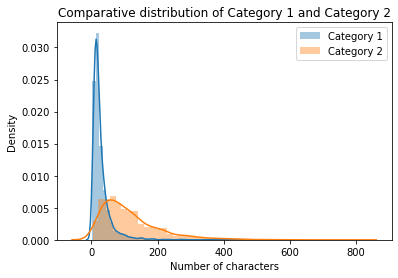

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(lengths1, label='Category 1')
sns.distplot(lengths2, label='Category 2')
# sns.distplot(lengths['Slogans'])
# sns.distplot(lengths['Causal_Oversimplification'])
# sns.distplot(lengths['Slogans'], kde=False)
# sns.distplot(lengths['Causal_Oversimplification'], kde=False)
# for s in category1:
#   sns.distplot(lengths[s])
plt.legend()
plt.xlabel('Number of characters')
plt.title('Comparative distribution of Category 1 and Category 2')
plt.savefig('comparative.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

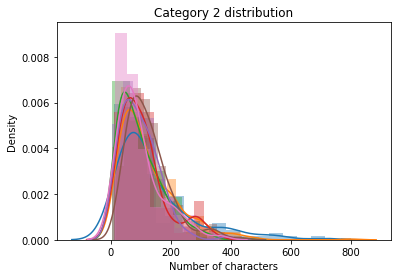

In [ ]:
for s in lengths:
  if s not in category1:
    sns.distplot(lengths[s])
plt.xlabel('Number of characters')
plt.title('Category 2 distribution')
plt.savefig('Category2.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

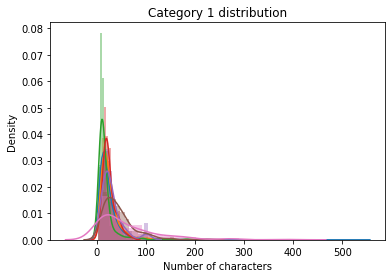

In [ ]:

for s in category1:
  sns.distplot(lengths[s])
plt.xlabel('Number of characters')
plt.title('Category 1 distribution')
plt.savefig('Category1.png')

In [ ]:
for s in category1:
  print(s, end=', ')

Loaded_Language, Name_Calling,Labeling, Repetition, Slogans, Thought-terminating_Cliches, Exaggeration,Minimisation, Flag-Waving, 